# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linal

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [353]:
USER_NAME = u"Балес".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \dfrac{d L}{d w} = (\sigma(g(x)) - y) * x + \dfrac{w}{C} $$

## Имплементация (5 баллов)

In [354]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, mini_batch_sizes=5, verbose=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.mini_batch_sizes = mini_batch_sizes
        self.verbose = verbose
    
    def _sigma(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _regul(self, w, c):
        return w * 2 / c
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.w = np.random.normal(loc=0.05, size=X.shape[1] + 1, scale=0.1) # генерируем коэф-ты
        self.partial_fit(X, y)
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        x_train = np.c_[np.ones(X.shape[0]), X] # добавляем свободный член
        ###
        ### вычисляем сколько не хватаем эл-ов до кратности self.mini_batch_sizes
        ###
        intInBatchesSz = int(x_train.shape[0] / self.mini_batch_sizes) * self.mini_batch_sizes
        ###
        data = np.c_[x_train, y] # для удобства permutation
        ###
        ### добавляем произвольные эл-ы из X в наш x_train, 
        ### чтобы x_train.shape[0] было кратно self.mini_batch_size
        ###
        if intInBatchesSz != x_train.shape[0]:
            delta = intInBatchesSz + self.mini_batch_sizes - x_train.shape[0]
            data = np.concatenate((data, np.random.permutation(data)[:delta]), axis=0)
        ###

        for epoch in xrange(self.max_epoch):
            alpha = self.alpha / (epoch + 1)
            permuteData = np.random.permutation(data) # делаем выборку минибатчей
            for i in xrange(0, permuteData.shape[0], self.mini_batch_sizes):
                x_ = permuteData[i:i + self.mini_batch_sizes, :-1]
                y_ = permuteData[i:i + self.mini_batch_sizes, -1:]                
                arr_w = []
                for j in xrange(self.mini_batch_sizes):
                    sg = self._sigma(np.dot(x_[j], self.w)) # вычисляем сигмойду
                    ###
                    ### считаем градиент с учётом регуляризации
                    ###
                    gd = (sg - y_[j]) * x_[j] + self._regul(self.w, self.C)
                    ###
                    arr_w.append(self.w - alpha * gd) # накапливаем коэф-ты
                self.w = np.array(arr_w).mean(axis=0) # находим среднее значение весов (коэф-ов)
            if self.verbose == True:
                sg = self._sigma(np.dot(x_train, self.w))
                print "[%d] %f" % (epoch, np.mean(-y * np.log(sg) - (1 - y) * np.log(1 - sg)))
                            
        return self    
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        
        X = np.c_[np.ones(X.shape[0]), X]
        y_hat = (np.dot(X, self.w) > 0).astype('int')
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        x_train = np.c_[np.ones(X.shape[0]), X]
        return self._sigma(-np.dot(x_train, self.w))        


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

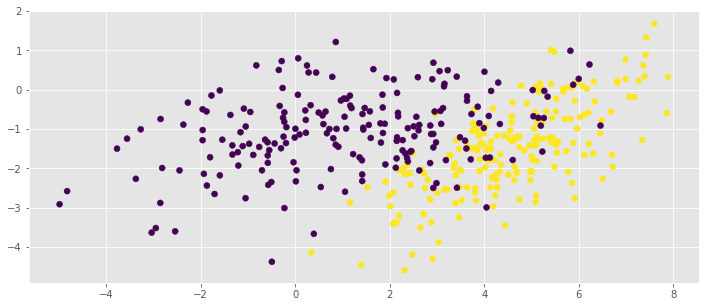

In [355]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [356]:
model = MySGDClassifier(mini_batch_sizes=20, alpha=0.8, C=1000, max_epoch=30, verbose=True)
model.fit(X, y)

[0] 0.673122
[1] 0.445539
[2] 0.373008
[3] 0.362832
[4] 0.361023
[5] 0.351772
[6] 0.348234
[7] 0.346931
[8] 0.345741
[9] 0.341221
[10] 0.339589
[11] 0.338333
[12] 0.337116
[13] 0.336051
[14] 0.334699
[15] 0.333974
[16] 0.332585
[17] 0.332244
[18] 0.330989
[19] 0.330940
[20] 0.330014
[21] 0.329181
[22] 0.328516
[23] 0.327928
[24] 0.327485
[25] 0.327172
[26] 0.326506
[27] 0.326083
[28] 0.325696
[29] 0.325360


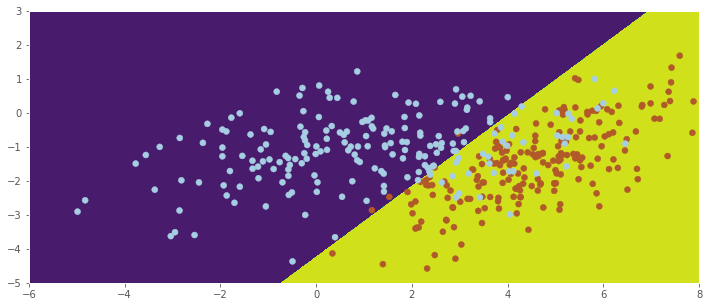

In [357]:
import matplotlib as pl
h = 0.01
x_min, x_max = -6, 8
y_min, y_max = -5, 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


xr = xx.ravel()
yr = yy.ravel()
xy = np.vstack((xr, yr)).T
/
y_ = model.predict(xy)

y_ = y_.reshape(xx.shape)
plt.contourf(xx, yy, y_)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=pl.cm.Paired)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [358]:
from sklearn.datasets import make_classification

In [359]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

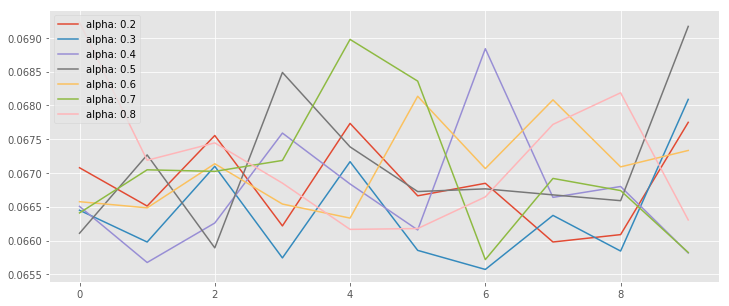

In [360]:
for alpha in np.arange(0.2, 0.8, 0.1):
    model = MySGDClassifier(alpha=alpha, mini_batch_sizes=20, C=1000.0, max_epoch=1)
    model.fit(X, y)
    x_train = np.c_[np.ones(X.shape[0]), X]
    ls = np.empty(10)
    for i in xrange(ls.shape[0]):
        model.partial_fit(X, y)
        sg = model._sigma(np.dot(x_train, model.w))
        ls[i] = np.mean(-y * np.log(sg) - (1 - y) * np.log(1 - sg))
    plt.plot(np.arange(ls.shape[0]), ls, label='alpha: {}'.format(alpha))
plt.legend()    

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

/home/balya/TechnoSphere/py-virt-env/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
/home/balya/TechnoSphere/py-virt-env/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in true_divide
/home/balya/TechnoSphere/py-virt-env/lib/python2.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in subtract


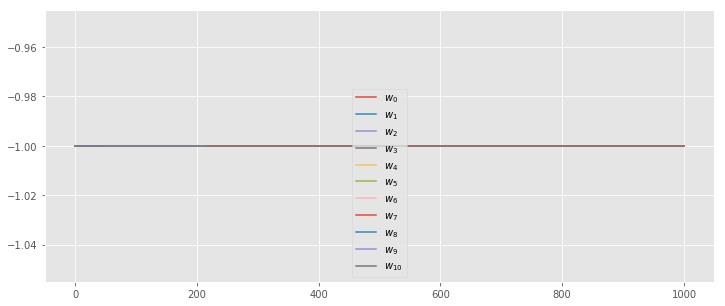

In [363]:
ws = np.empty([10, X.shape[1] + 1])
for idx, c in enumerate(np.logspace(3, -3, 10)):
    model = MySGDClassifier(alpha=0.8, mini_batch_sizes=30, C=c, max_epoch=2)
    model.fit(X, y)
    ws[i] = model.w
for idW in xrange(ws.shape[1]):
    l = r'w_{}'.format(idW)
    plt.plot(np.logspace(3, -3, 10), ws[:, idW], label=r'$w_{%d}$' % idW)
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [410]:
# Загрузка данных целиком
#df_list = []
#for chunk in range(1,5):
#    filepath = './trainingData_tabular_chunk%d.csv' % chunk
#    df_list.append(pd.read_csv(filepath, sep=','))
#df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [411]:
df_data.shape

(500000, 45)

In [412]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [413]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [414]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [415]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

cnt_uniq_cards = np.concatenate(
    (df_data['player_hero_card_id'].unique(), 
     df_data['opponent_hero_card_id'].unique())
)

le = LabelEncoder()
le.fit(cnt_uniq_cards)
del cnt_uniq_cards
ohe = OneHotEncoder()
ohe.fit(np.arange(le.classes_.shape[0]).reshape(-1,1))
print 'Count {} unique hero card'.format(le.classes_.shape[0])

Count 9 unique hero card


In [416]:
pl_hcid_ohe = ohe.transform(
    le.transform(df_data['player_hero_card_id']).reshape(-1,1)
).toarray()
opp_hcid_ohe = ohe.transform(
    le.transform(df_data['opponent_hero_card_id']).reshape(-1,1)
).toarray()
for i in xrange(pl_hcid_ohe.shape[1]):
    df_data['player_hcid_onehot_%d' % i] = pl_hcid_ohe[:, i]
    df_data['opponent_hcid_onehot_%d' % i] = opp_hcid_ohe[:, i]
df_data = df_data.drop(['player_hero_card_id', 'opponent_hero_card_id'], axis=1)

del pl_hcid_ohe, opp_hcid_ohe

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [417]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [418]:
X = df_data.iloc[:,1:].values
y = df_data.iloc[:,0].values

In [419]:
sclaer = StandardScaler()
model = MySGDClassifier(alpha=0.8, max_epoch=1, mini_batch_sizes=20, C=100)

scale_model = Pipeline([('scaler', sclaer), ('model', model)])
scale_model.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=100, alpha=0.8, max_epoch=1, mini_batch_sizes=20,
        verbose=None))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [420]:
df_list = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list)

df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

pl_hcid_ohe = ohe.transform(
    le.transform(df_data_test['player_hero_card_id']).reshape(-1,1)
).toarray()
opp_hcid_ohe = ohe.transform(
    le.transform(df_data_test['opponent_hero_card_id']).reshape(-1,1)
).toarray()
for i in xrange(pl_hcid_ohe.shape[1]):
    df_data_test['player_hcid_onehot_%d' % i] = pl_hcid_ohe[:, i]
    df_data_test['opponent_hcid_onehot_%d' % i] = opp_hcid_ohe[:, i]
df_data_test = df_data_test.drop(['player_hero_card_id', 'opponent_hero_card_id'], axis=1)

del pl_hcid_ohe, opp_hcid_ohe

In [421]:
from sklearn.metrics import roc_auc_score

y = np.loadtxt('deprecated_testLabels.txt')
X = df_data_test.iloc[:,1:].values

y_hat = scale_model.predict_proba(X)

print 'ROC_AUC:', roc_auc_score(y, y_hat)

ROC_AUC: 0.261090144094
